## Model training

We use data from a file or a function generation to train a perception surrogate $g(\Delta x)$.
In this case $\Delta x$ is defined as the relative position (distance) between a tree and the drone: $\Delta x = \| x - t_i \|$

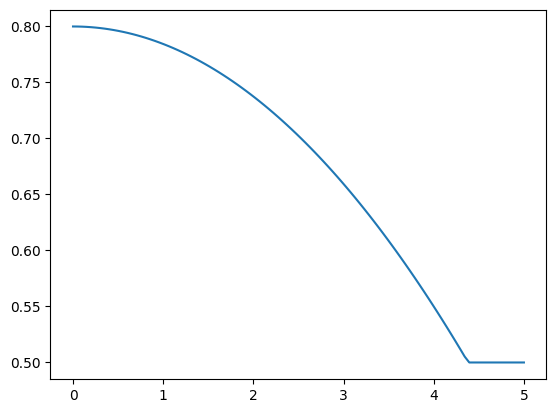

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data():
  """
  This function returns a set of x (relative angle and/or distance) and y (confidences) for the perception model
  """
  x = np.linspace(0, 5, 100)
  y = -(x/8)**2 + 0.8
  y = np.clip(y, a_min=0.5, a_max=1.0)
  
  return x, y

x_data, y_label = generate_data()

plt.plot(data[0], data[1])
plt.show()

def load_data():
  # TODO
  pass

## Train surrogate model

With the previous data, train a surrogate model (gaussian process or NN)

In [ ]:
# TODO: Define a simple NN
# TODO: Define the GP

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# TODO: Train

## Define the working environment

The problem definition is as follows:

$x$ state of the robot defined by the position of the drone and its velocity [x, y ,z, vx, vy, vz]

$f(x, u)$ state transition function for the drone

$u$ acceleration commands to the drone [ax, ay, az]

$t \in T$ tree positions for the $T$ trees [[tx_1, ty_2], ... , [tx_T, ty_T]]

$\lambda$ belief for the trees maturity confidence [\lambda_1, ..., \lambda_T] (values from 0 to 1). For practicity, it can be seen as part of $x$

$z$ observation vector for the tree maturity confidence [z_1, ..., z_T] (values from 0 to 1)

$g(\Delta x)$ observation surrogate. It is applied to every tree.

$b(\lambda, z)$ bayesian update to the previous belief.

$H(\lambda)$ entropy function for the belief defined (for the case of binary distribution) as: $-\lambda \log{\lambda} - (1-\lambda) \log(1-\lambda)$.

$J(\lambda)$ the cost function of the MPC defined as: $\sum_{1, ..., n} \delta_1 H(\lambda_i) * \delta_2 \Delta x_i^2 + \delta_3 \|u\|$. They correspond to trying to reduce the entropy for each of the trees using $\Delta x_i^2$ to guide the planner when there is no observation, and reduce the control inputs.

The steps of the system are as follows:
1. Load learned $g()$ which works for one tree.
2. Initialize $x$ in a $x_0$ position, $\lambda$ with $0.5$ values for each tree, and $t$ as known.
3. Run the NMPC from $x$ for $N$ iterations. In each step:
  - Compute $\Delta x$ for each tree with the new drone $x$.
  - Get estimation from NN for each tree: $z = g(\Delta x)$.
  - Fuse the estimation in $\lambda$ for each tree: $\lambda_{k} = b(\lambda_{k-1}, z)$
4. Apply the solution from the MPC.
5. Get a real observation.
6. Integrate the real observation into $\lambda$.
7. Go back to step 3.

In [ ]:
# TODO define the MPC model and cost function with equations to:

  # TODO: compute \Delta x for each tree
  # TODO: get estimation from g() for each tree
  # TODO: Fuse the estimation in lambda for each tree

# TODO define the MPC opt function.

# TODO Main

# Initialize x_0, lambda, and t

# Main loop

  # 3. Run MPC

  # 4. Apply command to the drone updating its pose

  # 5. Get a real observation

  # 6. Integrate observation into lambda
